In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prepare import *
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from metrics import *
from sklearn.ensemble import RandomForestRegressor
from trasnformer import *

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def invert_sq(x):
    return x ** 2

In [31]:
data = pd.read_csv("../data/train.csv")
data = data[(data["Sales"] < 9000)]

y = data["Sales"]
X = data

X, y = remove_outliers_split_2(X, y)
y = y ** 0.5


transformer = Transformer()

transformer.fit(X, False)
X = transformer.transform_lgbm(X, False)

#transformer.fit_scaler(X)
#X = transformer.scale(X)

#transformer.fit_encoder(X)
#X = transformer.encode(X)

rare_sections = X[X["Sales"] < 50]["ExtraSection"]
rare_brands = X[X["Sales"] < 50]["Brand"]

Int64Index([11982, 14166, 16131], dtype='int64')


In [32]:
def replaceSection(x, name, values):
    section = x[name]
    if section in values.values:
        return "Rare"
    return str(section)

X['ExtraSection'] = X.apply(lambda x : replaceSection(x, "ExtraSection", rare_sections), axis=1)
X['Brand'] = X.apply(lambda x : replaceSection(x, "Brand", rare_brands), axis=1)


sales_dict = {}
for key in transformer.brand_map.keys():
    section = transformer.brand_map[key]
    
    sales = section["Rating"].median()
    sales_dict[key] = sales

def put_brand_sales(x):
    brand = x["Brand"]
    if brand in sales_dict.keys():
        return sales_dict[brand] ** 0.5
    return 0

X['Brand sales'] = X.apply(lambda x : put_brand_sales(x), axis=1)

X.drop(columns=["Sales"], inplace=True)

In [33]:
transformer.fit_encoder(X)
X = transformer.encode(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
# X_train, y_train = remove_outliers_split(X_train, y_train)
X_train[X_train["Brand sales"]>0]

Comments  Average price  Days in stock  Days with sales  Rating  \
20356   5.656854     261.060172           20.0               23     2.5   
18175  19.773720     607.000000            9.0               19     2.5   
10320   5.477226     783.118421           31.0               26     2.5   
12446  16.822604     238.050835           29.0               30     1.5   
543     9.486833    1655.000000           16.0               13     1.5   
...          ...            ...            ...              ...     ...   
6676   34.942810    1487.462500           31.0               30     1.5   
9481    3.162278     240.950000           22.0               18     2.5   
2273    4.000000    1162.357895           30.0               31     1.5   
9055    9.327379    1922.500000           27.0               29     1.5   
14876   2.000000     370.364486           12.0               11     1.5   

       Basic Sale  Discount  Price scale  Brand sales    0  ...  1446  1447  \
20356        40.0     175.0    -0.436749     1.581139  0.0  ...   0.0   0.0   
18175        70.0       0.0    -0.386123     1.581139  0.0  ...   0.0   0.0   
10320        65.0      45.0    -0.426706     1.581139  0.0  ...   0.0   0.0   
12446        64.0     123.0    -0.493896     1.224745  0.0  ...   0.0   0.0   
543          59.0     213.0    -0.470372     1.224745  0.0  ...   0.0   0.0   
...           ...       ...          ...          ...  ...  ...   ...   ...   
6676         68.0    2517.0    -0.298643     1.224745  0.0  ...   0.0   0.0   
9481         50.0     199.0    -0.497354     1.581139  0.0  ...   0.0   0.0   
2273         51.0     254.0    -0.357753     1.224745  1.0  ...   0.0   0.0   
9055         53.0     429.0    -0.465071     1.224745  0.0  ...   0.0   0.0   
14876        57.0      48.0    -0.469032     1.224745  0.0  ...   0.0   0.0   

       1448  1449  1450  1451  1452  1453  1454  1455  
20356   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
18175   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
10320   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
12446   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
543     0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
...     ...   ...   ...   ...   ...   ...   ...   ...  
6676    0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
9481    0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
2273    0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
9055    0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  
14876   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  

[263 rows x 1465 columns]

In [35]:
total=X.isnull().sum().sort_values(ascending=False)
percent=total/len(X)*100
temp=pd.concat([total, percent], axis=1, keys=['Total', '%'])
temp=pd.concat([temp, X.dtypes], axis=1)
temp.loc[(temp['%']>0)]

Empty DataFrame
Columns: [Total, %, 0]
Index: []

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 200, max_depth=13)

xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [94]:
evaluate(xgb_model, X_train, y_train)
evaluate(xgb_model, X_test, y_test)

SMAPE: 58.01685424645434
SMAPE: 70.41498826215637


In [232]:
regr = RandomForestRegressor(n_jobs=-1, max_depth=11, n_estimators=60, verbose=2, criterion="absolute_error")
regr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 60building tree 2 of 60
building tree 3 of 60

building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.2min


building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 12.7min finished


RandomForestRegressor(criterion='absolute_error', max_depth=11, n_estimators=60,
                      n_jobs=-1, verbose=2)

In [233]:
evaluate(regr, X_train, y_train, invert_sq)
evaluate(regr, X_test, y_test, invert_sq)

SMAPE: 16.32759704988574
SMAPE: 19.768598924734253


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:    0.0s finished


In [36]:
regr_small = RandomForestRegressor(n_jobs=-1, max_depth=12, n_estimators=12, verbose=2, criterion="absolute_error")
regr_small.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 12building tree 2 of 12
building tree 3 of 12

building tree 4 of 12
building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  2.7min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.8min remaining:   33.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.9min finished


RandomForestRegressor(criterion='absolute_error', max_depth=12, n_estimators=12,
                      n_jobs=-1, verbose=2)

In [37]:
evaluate(regr_small, X_train, y_train, invert_sq)
evaluate(regr_small, X_test, y_test, invert_sq)

SMAPE: 15.851500347129988
SMAPE: 20.117389543632903


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished


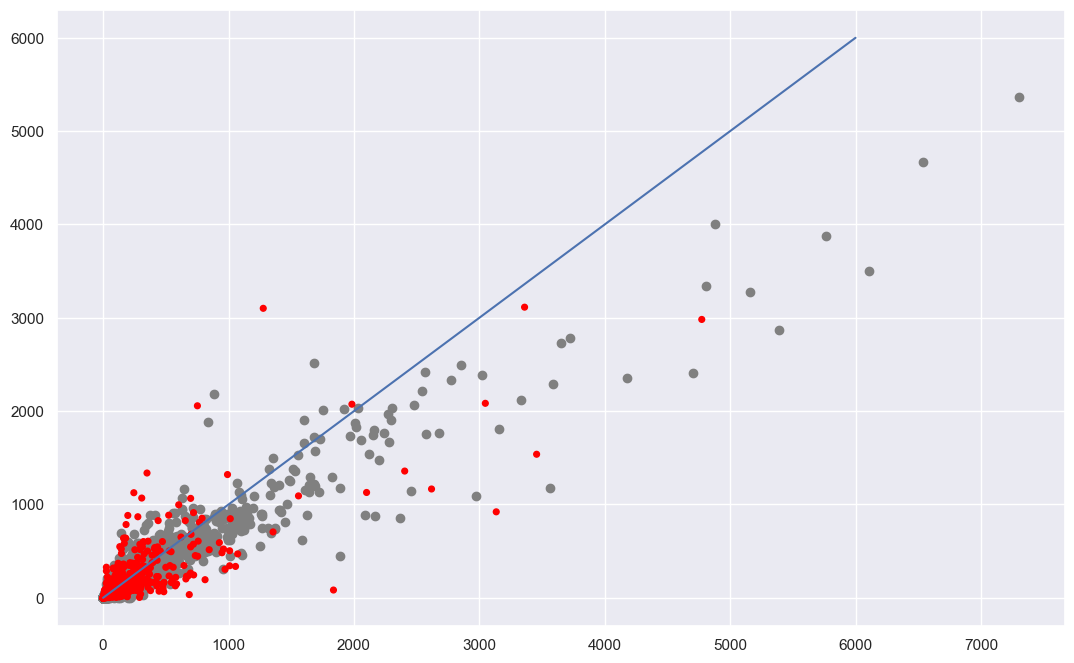

In [38]:
train_pred = invert_sq(regr_small.predict(X_train))
test_pred = invert_sq(regr_small.predict(X_test))

def transform_pred(x):
    #if x < 2000:
    #    return x
    #if x < 5000:
    #    return x * 1.8
    return x

train_pred = [transform_pred(x) for x in train_pred]
test_pred = [transform_pred(x) for x in test_pred]

plt.figure(figsize=(13,8))
plt.scatter(invert_sq(y_train), train_pred, color='gray')
plt.scatter(invert_sq(y_test), test_pred, color='red', s=[17 for n in range(len(y_test))])
plt.plot(np.linspace(0, 6000, 10), np.linspace(0, 6000, 10), c = 'b')

In [186]:
print(smape(invert_sq(y_train), train_pred))
print(smape(invert_sq(y_test), test_pred))

16.45706620054062
18.995065848082753


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished


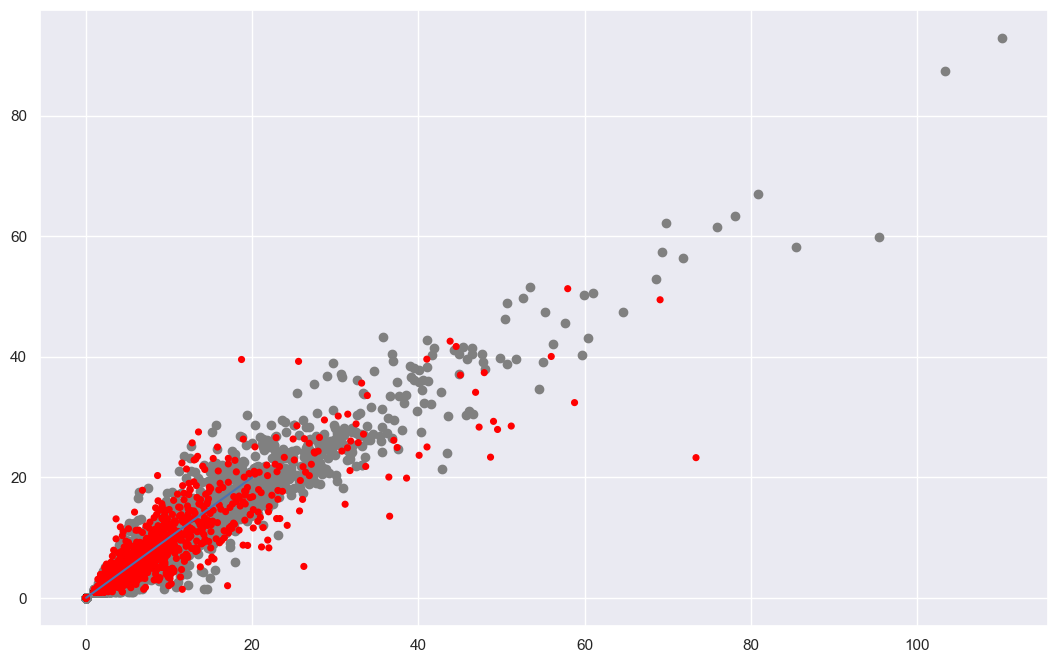

In [123]:
plt.figure(figsize=(13,8))
plt.scatter((y_train), (regr.predict(X_train)), color='gray')
plt.scatter((y_test), (regr.predict(X_test)), color='red', s=[17 for n in range(len(y_test))])
plt.plot(np.linspace(0, 20, 10), np.linspace(0, 20, 10), c = 'b')

In [189]:
val_data = pd.read_csv("../data/test.csv")
val_data.head()

Id                                               Name  \
0   0                                     Помпа для воды   
1   1                                    Термопот BN-348   
2   2          NEOLUX HLG-69 HEPA фильтр для пылесоса LG   
3   3                               Аппарат для педикюра   
4   4  Пульт Huayu H-LCD1510 (20LJ02) для телевизоров...   

                                            Category   Brand  \
0  /Техника для кухни/Приготовление напитков/Помп...  Majava   
1  /Техника для кухни/Приготовление напитков/Терм...    Beon   
2  /Техника для дома/Аксессуары для пылесосов/Фил...  NEOLUX   
3  /Красота и здоровье/Косметические аппараты/Апп...  CENTEK   
4  /Техника для дома/Пульты управления/Пульты тел...   HUAYU   

                      Seller Color  Comments  Final price  Max price  \
0    Бобров Вячеслав Юрьевич   NaN       2.0        277.0      277.0   
1                ТЕХПРОМ ООО   NaN       5.0       2211.0     2211.0   
2        ПКФ НЕВА-ФИЛЬТР ООО   NaN      19.0        490.0      490.0   
3                ЛИВСИТИ ООО   NaN       2.0        807.0      807.0   
4  Дулгер Дарья Сергеевна ИП   NaN       3.0        426.0      440.0   

   Min price  Average price  Days in stock  Days with sales  Rating  \
0      250.0     266.290323           16.0               14  0,0000   
1     2211.0    2211.000000            7.0                8  3,0000   
2      450.0     476.884615           31.0               22  5,0000   
3      807.0            NaN           31.0                0  4,0000   
4      426.0     426.000000           31.0                5  5,0000   

   Basic Sale  Basic Sale Price  Base price  \
0        50.0             360.0       720.0   
1        40.0            2664.0      4440.0   
2        30.0             490.0       700.0   
3        15.0             807.0       950.0   
4         3.0             426.0       440.0   

                                       full_category  
0  Бытовая техника/Техника для кухни/Приготовлени...  
1  Бытовая техника/Техника для кухни/Приготовлени...  
2  Бытовая техника/Техника для дома/Аксессуары дл...  
3  Бытовая техника/Красота и здоровье/Косметическ...  
4  Бытовая техника/Техника для дома/Пульты управл...

In [190]:
def inv(x):
    return x
    
val_data = transformer.transform_lgbm(val_data, False)

val_data['ExtraSection'] = val_data.apply(lambda x : replaceSection(x, "ExtraSection", rare_sections), axis=1)
val_data['Brand'] = val_data.apply(lambda x : replaceSection(x, "Brand", rare_brands), axis=1)

val_data = transformer.encode(val_data)

res = regr.predict(val_data)
res = [transform_pred(x) for x in invert_sq(res)]

save_res(res, inv)
val_data.head()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 120 out of 120 | elapsed:    0.0s finished


Comments  Average price  Days in stock  Days with sales  Rating  \
0  1.414214     266.290323           16.0               14     0.0   
1  2.236068    2211.000000            7.0                8     0.5   
2  4.358899     476.884615           31.0               22     2.5   
3  1.414214     807.000000           31.0                0     1.5   
4  1.732051     426.000000           31.0                5     2.5   

   Basic Sale  Discount  Price scale    0    1  ...  1448  1449  1450  1451  \
0        50.0      27.0    -0.443956  0.0  0.0  ...   0.0   0.0   0.0   0.0   
1        40.0       0.0    -0.443266  0.0  0.0  ...   0.0   0.0   0.0   0.0   
2        30.0      40.0    -0.433852  0.0  0.0  ...   0.0   0.0   0.0   0.0   
3        15.0       0.0    -0.473626  0.0  0.0  ...   0.0   0.0   0.0   0.0   
4         3.0      14.0    -0.461659  0.0  0.0  ...   0.0   0.0   0.0   0.0   

   1452  1453  1454  1455  1456  1457  
0   0.0   0.0   0.0   1.0   0.0   0.0  
1   0.0   0.0   0.0   1.0   0.0   0.0  
2   0.0   0.0   0.0   1.0   0.0   0.0  
3   0.0   0.0   0.0   1.0   0.0   0.0  
4   0.0   0.0   0.0   1.0   0.0   0.0  

[5 rows x 1466 columns]

In [137]:
old_data=pd.read_csv("../data/submission_old.csv")

In [138]:
res_blend = invert_sq(res) * 0.5 + old_data["Expected"] * 0.5

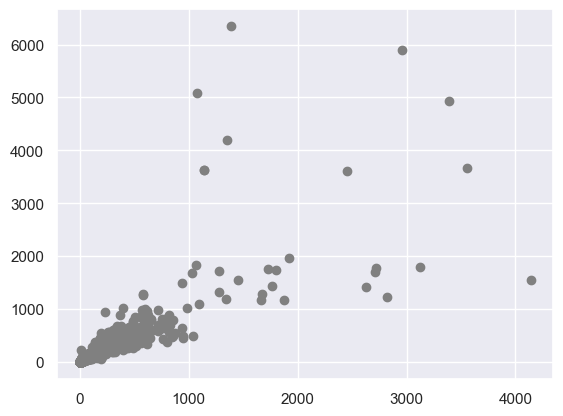

In [191]:
def inv(x):
    return x
    
plt.scatter(old_data["Expected"], res, color='gray')
save_res(res_blend, inv)


In [7]:
import hyperopt
from hyperopt import fmin, tpe, hp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from hyperopt.pyll import scope
from sklearn.metrics import make_scorer

# Define the search space for the hyperparameters
space = {
        'n_estimators': scope.int(hp.quniform('n_estimators', 70, 200, 10)),
        'max_depth': scope.int(hp.quniform('max_depth', 13, 20, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
        'n_jobs': -1
    }

def my_custom_loss_func(y_true, y_pred):
    return smape(invert_sq(y_true), invert_sq(y_pred))

scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

# Define the objective function that hyperopt will minimize
def objective(params):
    model = RandomForestRegressor(**params)
    cv_scores = -1 * cross_val_score(model, X, y, cv=5, scoring=scorer)
    return {'loss': cv_scores.mean(), 'status': hyperopt.STATUS_OK}

# Run the hyperparameter optimization
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

# Print the best hyperparameters
print(best)

 57%|█████▋    | 57/100 [7:32:47<5:41:35, 476.63s/trial, best loss: 22.701868458269814] 


KeyboardInterrupt: 

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

sk_reg = GradientBoostingRegressor(random_state=0)
sk_reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [19]:
evaluate(sk_reg, X_train, y_train, invert_sq)
evaluate(sk_reg, X_test, y_test, invert_sq)

SMAPE: 72.81849788530953
SMAPE: 74.22696724593536
